## Análise: tentando agrupar os clientes através do algoritmo K-Means e features relacionadas ao uso do app

In [189]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
from Utils.DataTransformer import DataTransformer
from Utils.DuckDb.DuckDb import DuckDb
from Utils.DatasetProcessor.DatasetProcessorUtils import DatasetProcessorUtils
from Utils.DataAnalysis import DataAnalysis
import pandas as pd
from Utils import PandasNotebookConfigs
import project_config
from Utils.Datetime import DatetimeUtils
from Utils.Dict import DictUtils
from Utils.Number import NumberUtils

In [191]:
PandasNotebookConfigs.config()

Ajustando display.float.format para %.4f
Ajustando prints de linhas e colunas


In [192]:
DUCK_DB = DuckDb()
DATA_TRANSFORMER = DataTransformer()
DATA_PROCESSOR_UTILS = DatasetProcessorUtils(DUCK_DB)
DATETIME_UTILS = DatetimeUtils()
DICT_UTILS = DictUtils()
DATA_ANALYSIS = DataAnalysis()
NUMBER_UTILS = NumberUtils()

In [193]:
# Determined by Silhouette method
HEAVY_USER_CLUSTER_NAME = 'Heavy User'
LIGHT_USER_CLUSTER_NAME = 'Light User'

In [194]:
CLUSTERS = [
    # From the heaviest to the lowest
    HEAVY_USER_CLUSTER_NAME,
    LIGHT_USER_CLUSTER_NAME
]

In [195]:
USAGE_COLUMNS = [
    'num_100', 'num_100-1M', 'num_100-2M',
    'num_25', 'num_25-1M', 'num_25-2M',
    'num_50', 'num_50-1M', 'num_50-2M',
    'num_75', 'num_75-1M', 'num_75-2M',
    'num_985', 'num_985-1M', 'num_985-2M',
    'num_unq', 'num_unq-1M', 'num_unq-2M',
    'total_secs', 'total_secs-1M', 'total_secs-2M',
    'predicted_is_churn'
]

In [196]:
df = DUCK_DB.load_table(
    project_config.PREDICTED_DATA_TABLE
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [197]:
df = df[df['no_churn_information'] == True]

In [198]:
len(df)

590951

In [199]:
# Get only the last safra
df = df[df['safra'] == 201702]
len(df)

173975

In [200]:
df = df[USAGE_COLUMNS]

In [201]:
df.head()

,num_100,num_100-1M,num_100-2M,num_25,num_25-1M,num_25-2M,num_50,num_50-1M,num_50-2M,num_75,num_75-1M,num_75-2M,num_985,num_985-1M,num_985-2M,num_unq,num_unq-1M,num_unq-2M,total_secs,total_secs-1M,total_secs-2M,predicted_is_churn
4,468,438.0000,855.0000,116,135.0000,193.0000,61,69.0000,88.0000,58,78.0000,98.0000,114,147.0000,142.0000,642,696.0000,979.0000,156533,157868.0000,256812.0000,False
15,383,651.0000,579.0000,188,289.0000,166.0000,80,175.0000,73.0000,46,97.0000,49.0000,46,82.0000,43.0000,551,1088.0000,645.0000,123768,215757.0000,169086.0000,False
21,258,384.0000,483.0000,103,54.0000,86.0000,47,9.0000,24.0000,27,8.0000,28.0000,32,21.0000,23.0000,194,130.0000,342.0000,78863,106043.0000,132765.0000,False
35,22,87.0000,94.0000,4,9.0000,82.0000,4,7.0000,44.0000,4,4.0000,19.0000,1,2.0000,21.0000,28,95.0000,207.0000,5712,22640.0000,33137.0000,False
39,86,86.0000,86.0000,21,21.0000,21.0000,8,8.0000,8.0000,1,1.0000,1.0000,2,2.0000,2.0000,115,115.0000,115.0000,23387,23387.0000,23387.0000,True


In [202]:
# test_df = df[:10_000].copy()
test_df = df.copy()

In [203]:
usage_df = test_df[USAGE_COLUMNS]

In [204]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=len(CLUSTERS), random_state=42)
customer_clusters = kmeans.fit_predict(usage_df)

In [205]:
# Assign cluster labels to the DataFrame
usage_df['cluster'] = kmeans.labels_

# View centroids (cluster centers)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=usage_df.columns[:-1])  # Exclude the cluster column
print("Cluster Centroids:")
print(centroids)

Cluster Centroids:
    num_100  num_100-1M  num_100-2M   num_25  num_25-1M  num_25-2M  num_50  \
0 1044.3453   1185.6222   1187.7527 180.5092   216.0376   225.0505 43.8759   
1  233.6559    270.9302    269.5180  69.8470    82.3159    84.6744 16.7214   

   num_50-1M  num_50-2M  num_75  num_75-1M  num_75-2M  num_985  num_985-1M  \
0    51.2725    53.4023 29.1342    34.2988    35.3552  34.1155     39.6061   
1    19.3778    20.1350 10.3500    12.1785    12.4921  11.1827     13.2128   

   num_985-2M  num_unq  num_unq-1M  num_unq-2M  total_secs  total_secs-1M  \
0     40.1951 959.5121   1097.1117   1108.3064 271019.0848    308761.6324   
1     13.2053 262.6806    306.3890    308.1573  62752.5947     73005.0933   

   total_secs-2M  predicted_is_churn  
0    310068.5525              0.2692  
1     72905.4517              0.2508  


In [206]:
# Compute the standard deviation of each feature across clusters
feature_importance = centroids.std(axis=0).sort_values(ascending=False)

# Get the top 10 features
top_10_features = feature_importance.head(10)
print("Top 10 Features diferenciando os Clusters:")
print(top_10_features)


Top 10 Features diferenciando os Clusters:
total_secs-2M   167699.6368
total_secs-1M   166705.0475
total_secs      147266.6475
num_100-2M         649.2900
num_100-1M         646.7849
num_100            573.2440
num_unq-2M         565.7909
num_unq-1M         559.1254
num_unq            492.7343
num_25-2M           99.2608
dtype: float64


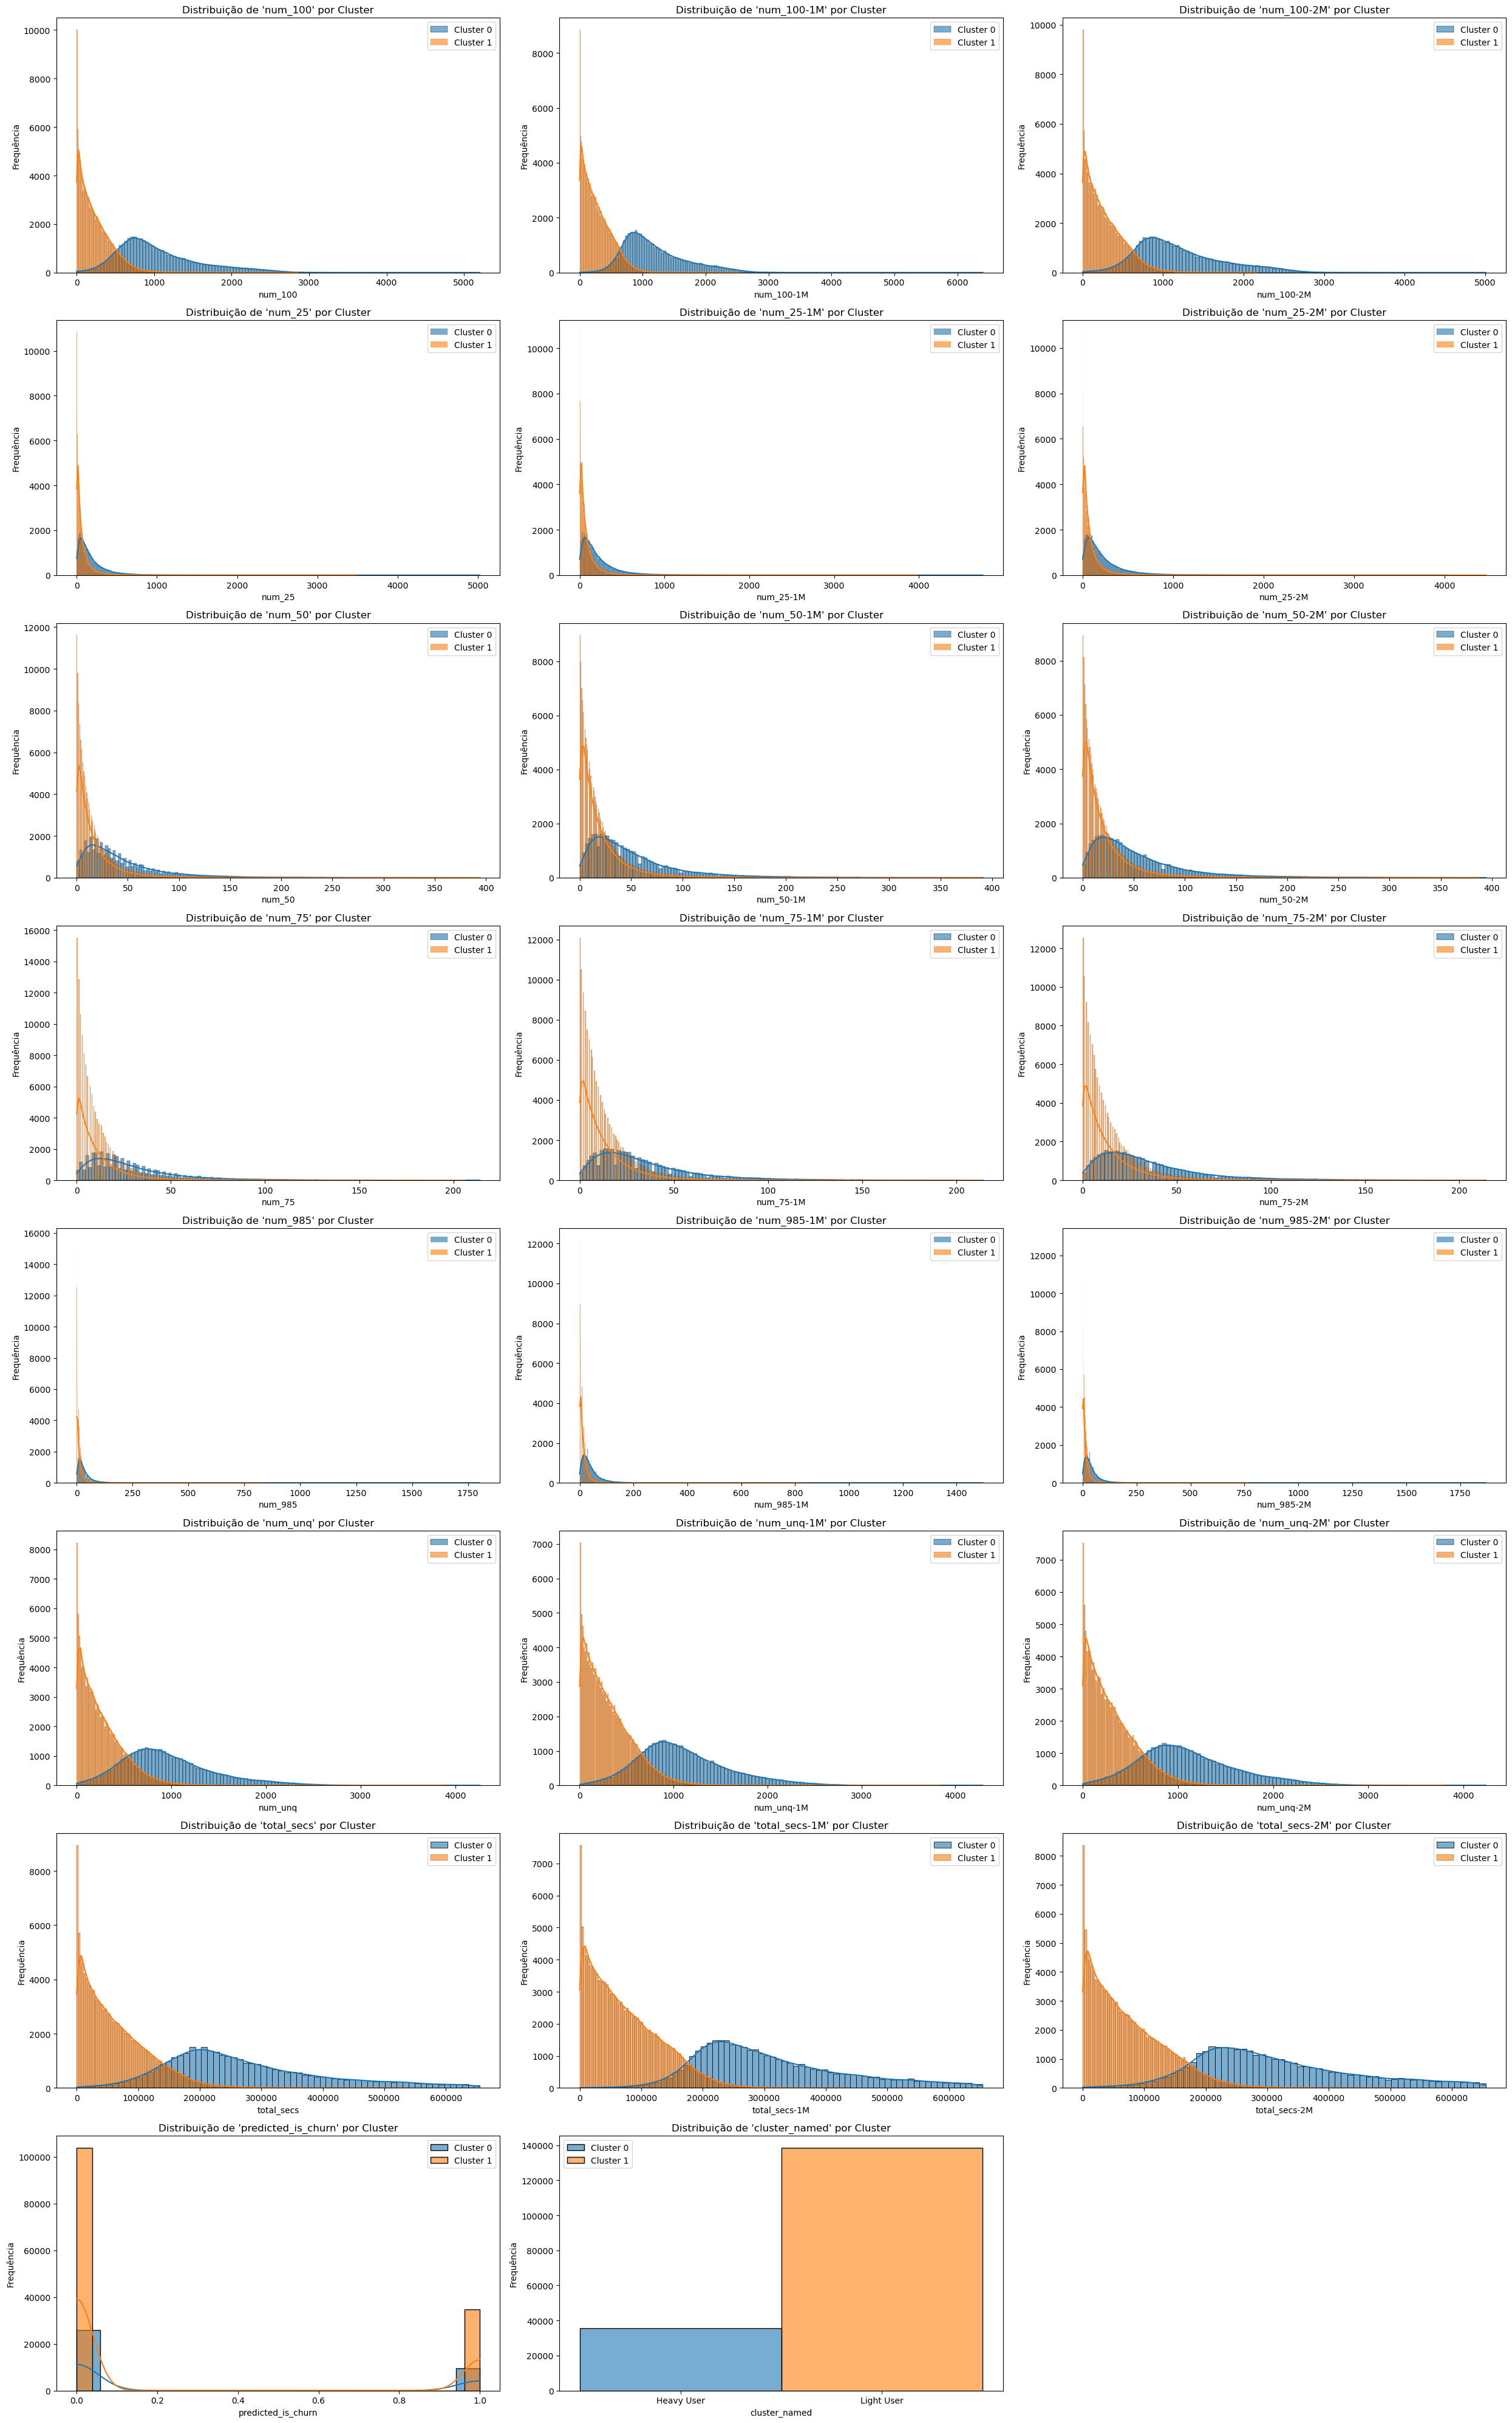

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Extract features (excluding 'cluster') and define the number of rows/columns
features = usage_df.drop('cluster', axis=1).columns
n_features = len(features)
n_cols = 3  # Number of figures per row
n_rows = math.ceil(n_features / n_cols)  # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, n_rows * 5))  # Adjust the figure size
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate through each feature and create a histogram
for i, feature in enumerate(features):
    ax = axes[i]
    for cluster_id in usage_df['cluster'].unique():
        sns.histplot(
            data=usage_df[usage_df['cluster'] == cluster_id],
            x=feature,
            kde=True,
            label=f'Cluster {cluster_id}',
            alpha=0.6,
            ax=ax  # Specify the subplot for this feature
        )
    ax.set_title(f"Distribuição de '{feature}' por Cluster")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequência")
    ax.legend()

# Hide unused subplots if the number of features is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [217]:
from typing import Dict


def get_cluster_value_map(df: pd.DataFrame) -> Dict[str, any]:
    field_to_consider = 'total_secs'

    # Order clusters by total_secs mean value
    cluster_mean_total_secs = {}
    for i in range(0, len(CLUSTERS)):
        cluster_df = df[df['cluster'] == i]
        cluster_mean_total_secs[i] = cluster_df[field_to_consider].mean()

    cluster_mean_total_secs = DICT_UTILS.sort_dict_by_values(cluster_mean_total_secs)

    cluster_names = {}
    sorted_clusters_keys = list(cluster_mean_total_secs.keys())
    sorted_clusters_keys.reverse()
    for index, key in enumerate(sorted_clusters_keys):
        # print(f'Cluster {key} = {CLUSTERS[index]}')
        cluster_names[key] = CLUSTERS[index]

    return cluster_names

In [218]:
# Giving names to clusters
def name_clusters(df: pd.DataFrame) -> pd.DataFrame:
    cluster_names = get_cluster_value_map(df)

    # Filling out the cluster_named column
    col_data = []
    for _, row in usage_df.iterrows():
        row_cluster = row['cluster']

        col_data.append(cluster_names[row_cluster])

    df['cluster_named'] = col_data
    return df

In [219]:
usage_df = name_clusters(usage_df)

In [220]:
usage_df.head(20)

,num_100,num_100-1M,num_100-2M,num_25,num_25-1M,num_25-2M,num_50,num_50-1M,num_50-2M,num_75,num_75-1M,num_75-2M,num_985,num_985-1M,num_985-2M,num_unq,num_unq-1M,num_unq-2M,total_secs,total_secs-1M,total_secs-2M,predicted_is_churn,cluster,cluster_named
4,468,438.0000,855.0000,116,135.0000,193.0000,61,69.0000,88.0000,58,78.0000,98.0000,114,147.0000,142.0000,642,696.0000,979.0000,156533,157868.0000,256812.0000,False,0,Heavy User
15,383,651.0000,579.0000,188,289.0000,166.0000,80,175.0000,73.0000,46,97.0000,49.0000,46,82.0000,43.0000,551,1088.0000,645.0000,123768,215757.0000,169086.0000,False,1,Light User
21,258,384.0000,483.0000,103,54.0000,86.0000,47,9.0000,24.0000,27,8.0000,28.0000,32,21.0000,23.0000,194,130.0000,342.0000,78863,106043.0000,132765.0000,False,1,Light User
35,22,87.0000,94.0000,4,9.0000,82.0000,4,7.0000,44.0000,4,4.0000,19.0000,1,2.0000,21.0000,28,95.0000,207.0000,5712,22640.0000,33137.0000,False,1,Light User
39,86,86.0000,86.0000,21,21.0000,21.0000,8,8.0000,8.0000,1,1.0000,1.0000,2,2.0000,2.0000,115,115.0000,115.0000,23387,23387.0000,23387.0000,True,1,Light User
49,401,573.0000,466.0000,160,60.0000,52.0000,15,26.0000,12.0000,18,18.0000,14.0000,12,16.0000,10.0000,491,329.0000,419.0000,105294,140762.0000,118356.0000,False,1,Light User
55,8,120.0000,220.0000,1,5.0000,22.0000,1,0.0000,2.0000,1,0.0000,2.0000,0,1.0000,1.0000,10,63.0000,212.0000,3030,32079.0000,53198.0000,True,1,Light User
63,139,85.0000,137.0000,8,28.0000,32.0000,1,9.0000,7.0000,3,3.0000,9.0000,1,5.0000,3.0000,151,127.0000,181.0000,36137,24814.0000,38614.0000,False,1,Light User
69,343,278.0000,218.0000,76,37.0000,37.0000,43,17.0000,14.0000,12,7.0000,10.0000,7,3.0000,2.0000,397,301.0000,258.0000,91116,67676.0000,54640.0000,False,1,Light User
75,645,620.0000,498.0000,541,141.0000,78.0000,108,44.0000,22.0000,57,25.0000,16.0000,44,42.0000,17.0000,845,459.0000,395.0000,192024,168681.0000,140239.0000,False,1,Light User


In [221]:
def get_usage_info_form_clusters(df: pd.DataFrame):
    cols = [
        'total_secs',
        'num_unq'
    ]

    cluster_values_map = get_cluster_value_map(df)

    for cluster in cluster_values_map:
        grp = df[df['cluster'] == cluster]
        print(f'Cluster {cluster_values_map[cluster]}')

        for col in cols:
            print(f'\t-> Mediana de {col}: {grp[col].median()}')
            # print(f'\t-> Média de {col}: {grp[col].mean()}')
            # print()

        print()
        # print(grp)


get_usage_info_form_clusters(usage_df)

Cluster Heavy User
	-> Mediana de total_secs: 242941.0
	-> Mediana de num_unq: 883.0

Cluster Light User
	-> Mediana de total_secs: 49389.0
	-> Mediana de num_unq: 203.0



In [222]:
from typing import List

plot_pizza = DataAnalysis().plot_pizza

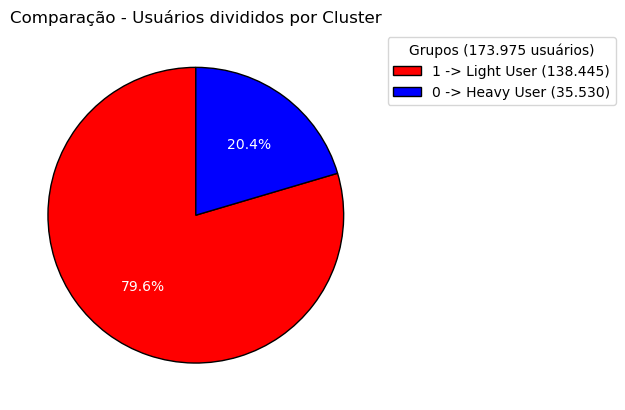

In [223]:
def compare_cluster_proportion(df: pd.DataFrame):
    cluster_value_map = get_cluster_value_map(df)

    counted = df['cluster'].value_counts()
    labels = []
    for i in counted.index:
        labels.append(
            f'{i} -> {cluster_value_map[i]} ({NUMBER_UTILS.format_integer_number(counted[i])})'
        )

    plot_pizza(
        value_counts=counted,
        labels=labels,
        title='Comparação - Usuários divididos por Cluster',
        legend=f'Grupos ({NUMBER_UTILS.format_integer_number(len(df))} usuários)',
        colors=['red', 'blue'],
        text_color='white'
    )

compare_cluster_proportion(usage_df)

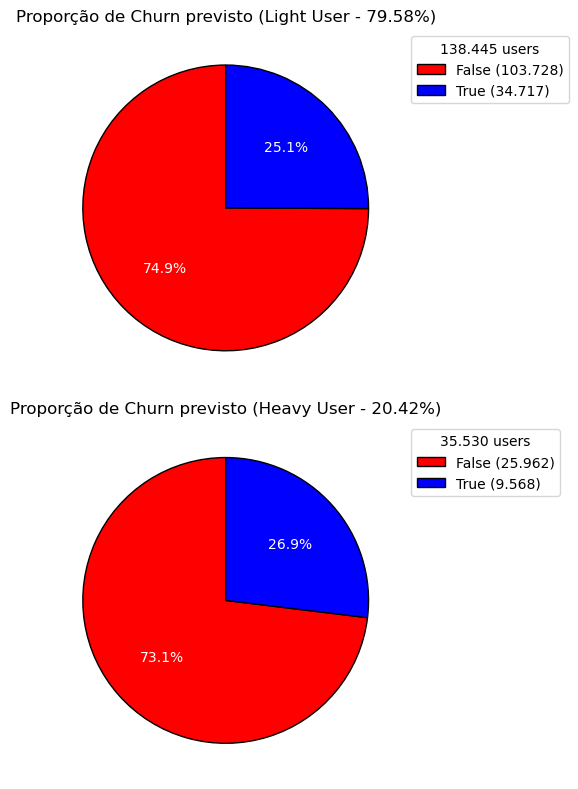

In [224]:
def compare_cluster_is_churn_proportion(df: pd.DataFrame):
    cluster_value_map = get_cluster_value_map(df)

    n_rows = len(CLUSTERS)
    n_cols = 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 8))  # Adjust the figure size
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    cluster_counted = df['cluster'].value_counts()
    for index, cluster in enumerate(cluster_counted.index):
        filtered_df =  df[df['cluster'] == cluster]
        is_churn_counted = filtered_df['predicted_is_churn'].value_counts()

        cluster_percentage = len(filtered_df) * 100 / len(df)

        plot_pizza(
            value_counts=is_churn_counted,
            labels=[f'{x} ({NUMBER_UTILS.format_integer_number(is_churn_counted[x])})' for x in is_churn_counted.index],
            title=f'Proporção de Churn previsto ({cluster_value_map[cluster]} - {cluster_percentage:.2f}%)',
            legend=f'{NUMBER_UTILS.format_integer_number(len(filtered_df))} users',
            ax=axes[index],
            colors=['red', 'blue'],
            text_color='white'
        )

    plt.tight_layout()
    plt.show()

compare_cluster_is_churn_proportion(usage_df)

# Conclusão
Podemos perceber 3 tipos de usuários:
- Usuários Casuais (usam menos a plataforma; são a grande maioria)
- Usuários Pesados (utilizam de forma intensa)

Quanto mais os usuários utilizam a plataforma, menos eles tendem a virar churn no futuro.

## Store this code

In [225]:
raise Exception('Stop here!')

Exception: Stop here!

In [ ]:
# Utilizando o método da Silhueta, pois ele foca na qualidade dos agrupamentos
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X = usage_df.copy()[USAGE_COLUMNS]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

range_n_clusters = list(range(2, 5))
silhouette_avg = []

for n_clusters in range_n_clusters:
    print(f'Cluster qty: {n_clusters}')
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg.append(silhouette_score(X_scaled, cluster_labels))

plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title("Análise da Silhueta")
plt.xlabel("Número de Clusters")
plt.ylabel("Média do Índice de Silhueta")
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

optimal_n_clusters = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]
print(f"O número ideal de clusters é {optimal_n_clusters} com índice de silhueta médio de {max(silhouette_avg):.2f}")


Cluster qty: 2


KeyboardInterrupt: 